In [1]:
from google.colab import drive
import os
%load_ext autoreload
%autoreload 2

drive.mount('/content/gdrive', force_remount=True)
os.chdir('/content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/src/data_preparation/')


Mounted at /content/gdrive


# Imports

https://discuss.pytorch.org/t/loaded-model-returns-different-predictions/77588/2

https://discuss.pytorch.org/t/model-shows-different-predictions-after-training-without-weight-update/75877/5



In [2]:
!pip install antspyx

     |████████████████████████████████| 300.4 MB 16 kB/s 
     |████████████████████████████████| 64 kB 2.7 MB/s 


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sp
from joblib import dump, load
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn')
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

In [4]:
import os
import sys
import time
import random
import argparse
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd

from mri_augmentation import *
sys.path.append("./../utils")
from base_mri import *
from utils import *

def generate_mri_dataset_reference(mri_reference_path,
                                output_path,
                                orientation = 'coronal',
                                orientation_slice = 50,
                                num_sampled_images = 5,
                                sampling_range = 3,
                                num_rotations = 3,
                                save_reference_file = True):

    '''
    Execute MRI metadata preparation for training the deep learning model. The final image will be generated only during training/test/validation step.

    Main Steps:

    - Select orientation of training.
    
    - Select slice indication.

    - Executes Data Augmentation (optional) generating more images based on rotation and flipping. 

    Parameters
    ----------
 
    mri_reference_path: path of the processed MRI reference file.
    
    output_path: path to save the metadata reference file.
    
    orientation: Orientation to slice the image. Values can be "coronal", "sagittal" or "axial".
    
    orientation_slice: Mark to slice the 3D image. Values range from 0 to 100. TODO: fix future bug if sampling_range is outside of the image.
    
    num_sampled_images: Number of images to sample.
    
    sampling_range: Range to sample new images from original 3D image, with reference to the orientation_slice.

    num_rotations: Number of different rotations to augment original image.

    save_reference_file: Flag to save the reference file or not.
    
    '''

    df_mri_reference = pd.read_csv(mri_reference_path)

    if not os.path.exists(output_path):
        print("Creating output path... \n")
        os.makedirs(output_path)

    df_mri_dataset = df_mri_reference.query("ORIENTATION == @orientation and VALID_IMAGE == True")
    df_mri_dataset['MAIN_SLICE'] = orientation_slice
    images= df_mri_reference['IMAGE_DATA_ID'].unique().tolist()
    
    print("Creating augmented samples...")
    df_samples = generate_augmented_slices(orientation_slice,sampling_range,num_sampled_images,preprocessed_images = images)
    df_mri_dataset = df_mri_dataset.merge(df_samples,on=['IMAGE_DATA_ID','SLICE'],how='inner').reset_index(drop=True)
    df_mri_dataset['SLICE_ID'] = df_mri_dataset['IMAGE_DATA_ID'] + '_' + df_mri_dataset['SLICE'].astype(str)
    
    if num_rotations > 0:
        print("Creating 2d image rotations...")
        df_samples_rot = generate_augmented_rotations(num_rotations=num_rotations,preprocessed_images=df_mri_dataset['SLICE_ID'])
        df_mri_dataset = df_mri_dataset.merge(df_samples_rot,on='SLICE_ID')

    print("Creating final reference file for prepared images...")
    if save_reference_file:
        now = datetime.now().strftime("%Y%m%d_%H%M")
        reference_file_name = 'PROCESSED_MRI_REFERENCE_' + orientation + '_' + str(orientation_slice) + '_samples_around_slice_' + str(num_sampled_images) +'_num_rotations_' + str(num_rotations) + '_'+ now + '.csv'
        df_mri_dataset.to_csv(output_path+reference_file_name,index=False)
        print("Processed MRI reference file saved at:",output_path+reference_file_name)
    return df_mri_dataset

def generate_augmented_slices(orientation_slice,sampling_range,num_sampled_images,preprocessed_images):
    random.seed(a=None, version=2)
    sampling_population = list(set(range(orientation_slice-sampling_range,orientation_slice+sampling_range+1)) - set([orientation_slice]))
    samples = [(img,random.sample(population= sampling_population,k=num_sampled_images)+[orientation_slice]) for img in preprocessed_images]
    df_samples  = pd.DataFrame(samples,columns=['IMAGE_DATA_ID','SLICE'])
    return df_samples.explode('SLICE').reset_index(drop=True)

def generate_augmented_rotations(num_rotations,preprocessed_images):
    random.seed(a=None, version=2)
    samples = [(img,random.sample(population= list(np.arange(-15,16,2)) ,k=num_rotations) + [0]) for img in preprocessed_images]
    df_samples  = pd.DataFrame(samples,columns=['SLICE_ID','ROTATION_ANGLE'])
    return df_samples.explode('ROTATION_ANGLE').reset_index(drop=True)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
import warnings
warnings.filterwarnings("ignore")

from scipy import ndimage
from torch.utils.data import Dataset
from torchvision import transforms as T

import numpy as np

class MRIDataset(Dataset):

     '''
     Builds a dataset loader component for PyTorch with the MRIs based on the filepath.
     '''

     def __init__(self, reference_table,target_column = 'MACRO_GROUP'):
          
          '''
          Initialization of the component

          Parameters
          ----------

          reference_table: Pandas DataFrame containing the reference for the subjects, images and their labels

          '''
          self.target_column = target_column
          self.reference_table = reference_table
          # self.transform_train = self.T.Compose([
          #      transforms.RandomCrop(32, padding=4),
          #      transforms.RandomRotation(degrees=15),
          #      transforms.ToTensor(),
          #      transforms.Normalize(rgb_mean, rgb_std),
          # ])
     def __len__(self):
          'Denotes the total number of samples'
          return self.reference_table.shape[0]

     def __getitem__(self, index):
          'Generates one sample of data'
          
          # Select sample
          sample = self.reference_table.iloc[index]

          # Load data and get label
          X = np.load(sample['IMAGE_PATH'])['arr_0']

          if 'ROTATION_ANGLE' in sample.index and sample['ROTATION_ANGLE'] != 0:
               X = ndimage.rotate(X, sample['ROTATION_ANGLE'], reshape=False)
                         
          X = X/X.max()
          y = sample[self.target_column]
          return X, y


In [6]:
os.chdir('/content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/src/model_training/')
# import mri_metadata_preparation

In [7]:
import torch
# from torch.nn.functional import one_hot
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, BCEWithLogitsLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, AdaptiveAvgPool2d
from torch.optim import Adam, SGD

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision.models as models

class SuperShallowCNN(Module):
    def __init__(self):
        super(SuperShallowCNN, self).__init__()
        self.features = Sequential(
            Conv2d(in_channels =1, out_channels =8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(num_features=8),
            ReLU(inplace=True),
            MaxPool2d(2,2),

            Conv2d(in_channels =8, out_channels =16, kernel_size=3, stride=1, padding=0),
            BatchNorm2d(num_features=16),
            ReLU(inplace=True),
            MaxPool2d(2,2),
            
            Conv2d(in_channels =16, out_channels =32, kernel_size=3, stride=1, padding=0),
            BatchNorm2d(num_features=32),
            ReLU(inplace=True),
            MaxPool2d(2,2),
            
            Conv2d(in_channels =32, out_channels =64, kernel_size=3, stride=1, padding=0),
            BatchNorm2d(num_features=64),
            ReLU(inplace=True),
            MaxPool2d(2,2),

            Conv2d(in_channels =64, out_channels =128, kernel_size=3, stride=1, padding=0),
            ReLU(inplace=True)
        )
        self.avgpool = AdaptiveAvgPool2d(output_size=(4, 4))
        self.classifier = Sequential(
            # Remember changing the x.view() number as well. It needs to be flattenend!
            Linear(in_features=128*4*4, out_features=128, bias=True),
            ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            Linear(in_features=128, out_features=64, bias=True),
            ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            # Linear(in_features=64, out_features=64, bias=True),
            # ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            Linear(in_features=64, out_features=1, bias=True)
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.size())
        x = self.avgpool(x)
        # print(x.size())

        # flattenning 
        x = x.view(-1,128*4*4)
        # print(x.size())
        logits = self.classifier(x)
        # print(logits.size())
        return logits

# nnn = SuperShallowCNN()
# nnn.forward(x)

In [8]:
import torch
# from torch.nn.functional import one_hot
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, BCEWithLogitsLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, AdaptiveAvgPool2d
from torch.optim import Adam, SGD

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision.models as models

class NeuralNetwork(Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.features = Sequential(
            Conv2d(in_channels =1, out_channels =8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(num_features=8),
            ReLU(inplace=True),
            MaxPool2d(2,2),

            Conv2d(in_channels =8, out_channels =16, kernel_size=3, stride=1, padding=0),
            BatchNorm2d(num_features=16),
            ReLU(inplace=True),
            MaxPool2d(2,2),
            
            Conv2d(in_channels =16, out_channels =32, kernel_size=3, stride=1, padding=0),
            BatchNorm2d(num_features=32),
            ReLU(inplace=True),
            MaxPool2d(2,2),
            
            Conv2d(in_channels =32, out_channels =64, kernel_size=3, stride=1, padding=0),
            ReLU(inplace=True)
        )
        self.avgpool = AdaptiveAvgPool2d(output_size=(8, 8))
        self.classifier = Sequential(
            # Remember changing the x.view() number as well. It needs to be flattenend!
            Linear(in_features=64*8*8, out_features=512, bias=True),
            ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            Linear(in_features=512, out_features=512, bias=True),
            ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            # Linear(in_features=512, out_features=512, bias=True),
            # ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            Linear(in_features=512, out_features=1, bias=True)

        )

    def forward(self, x):
        x = self.features(x)
        # print(x.size())
        x = self.avgpool(x)
        # print(x.size())
        # flattenning 
        x = x.view(-1,64*8*8)
        # print(x.size())
        logits = self.classifier(x)
        # print(logits.size())
        return logits

In [9]:
import time
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

import torch
# from torch.nn.functional import one_hot
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, BCEWithLogitsLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, AdaptiveAvgPool2d
from torch.optim import Adam, SGD,RMSprop

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision.models as models

from mri_dataset import MRIDataset
from mri_dataset_generation import generate_mri_dataset_reference

import sys
sys.path.append("./../data_preparation")
from train_test_split import train_test_split_by_subject

# sys.path.append("./../models")
# from neural_network import NeuralNetwork, SuperShallowCNN,create_adapted_vgg11

# %load_ext autoreload
# %autoreload 2

# Defining global variables
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

def run_mris_experiments(orientation_and_slices = [('coronal',list(range(45,56)))],
                          num_repeats = 3,
                          model='shallow_cnn',
                          classes=['AD','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211012_2041.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = None,
                          save_path = ''):

    results = []
    for orientation,slices in orientation_and_slices:
        mri_config['orientation'] = orientation
        for ii in range(1,num_repeats+1):
            for slice in slices:
                print("\n--------------------------------------------------------------------")
                print("--------------------------------------------------------------------")
                print(f"Running {orientation} - slice:{slice} with no data augmentation.")
                print("--------------------------------------------------------------------")
                print("--------------------------------------------------------------------\n")
                mri_config['slice'] = slice
                df_ref = generate_mri_dataset_reference(mri_reference_path = mri_config['mri_reference'],
                                    output_path = mri_config['output_path'],
                                    orientation = mri_config['orientation'],
                                    orientation_slice = mri_config['slice'],
                                    num_sampled_images = mri_config['num_samples'],
                                    sampling_range = mri_config['sampling_range'],
                                    num_rotations = mri_config['num_rotations'],
                                    save_reference_file = False)
                run_result = run_cnn_experiment(model = model,
                            model_name = 'cnn_'+orientation+str(slice)+str(ii),
                            classes = classes,
                            mri_reference = df_ref,
                            run_test = False,
                            compute_predictions = False,
                            prediction_dataset_path = '',
                            model_path = '',
                            additional_experiment_params = additional_experiment_params)
                run_result['orientation'] = orientation
                run_result['slice'] = slice
                run_result['run'] = ii
                run_result['RUN_ID'] = orientation+str(slice)+str(ii)
                results.append(run_result)
                if save_path != '' and save_path is not None:
                    df_results = pd.concat(results)
                    df_results.to_csv(save_path,index=False)

    df_results = pd.concat(results)
    if save_path != '' and save_path is not None:
        df_results.to_csv(save_path,index=False)
    return df_results


def run_experiments_for_ensemble(orientation_and_slices = [('coronal',list(range(45,56)))],
                          model='shallow_cnn',
                          classes=['AD','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211012_2041.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = None,
                          save_path = ''):

    predictions = []
    for orientation,slices in orientation_and_slices:
        mri_config['orientation'] = orientation
        for slice in slices:
            print("\n--------------------------------------------------------------------")
            print("--------------------------------------------------------------------")
            print(f"Running {orientation} - slice:{slice} with no data augmentation.")
            print("--------------------------------------------------------------------")
            print("--------------------------------------------------------------------\n")
            mri_config['slice'] = slice
            df_ref = generate_mri_dataset_reference(mri_reference_path = mri_config['mri_reference'],
                                output_path = mri_config['output_path'],
                                orientation = mri_config['orientation'],
                                orientation_slice = mri_config['slice'],
                                num_sampled_images = mri_config['num_samples'],
                                sampling_range = mri_config['sampling_range'],
                                num_rotations = mri_config['num_rotations'],
                                save_reference_file = False)
            prediction,_ = run_cnn_experiment(model = model,
                        model_name = 'cnn_'+orientation+str(slice),
                        classes = classes,
                        mri_reference = df_ref,
                        run_test = False,
                        compute_predictions = True,
                        prediction_dataset_path = '',
                        model_path = '',
                        additional_experiment_params = additional_experiment_params)
            prediction['orientation'] = orientation
            prediction['slice'] = slice
            prediction['RUN_ID'] = orientation+str(slice)
            predictions.append(prediction)

    df_predictions = pd.concat(predictions)
    # TODO: pivot table to make RUN_ID turn into columns for the prediction scores
    if save_path != '' and save_path is not None:
        df_predictions.to_csv(save_path,index=False)
    return df_predictions


def run_cnn_experiment(model = 'vgg11',
                       model_name = 'vgg11_2048_2048',
                       classes = ['AD','CN'],
                       mri_reference = '',
                       run_test = False,
                       compute_predictions = False,
                       prediction_dataset_path = '',
                       model_path = '',
                       additional_experiment_params = None):
    '''
    Run the MRI classification for AD or CN.

    Parameters
    ----------

    model: Neural network to be trained. Can be 'vgg11' or 'shallow'.
    
    model_name: Name to save the trained model.
    
    classes: classes to filter the dataset. options can be ['AD','CN','MCI']

    mri_reference: Path or file of the MRI reference that will be used to filter the validation/test sets and classes. 

    prediction_dataset_path: '/content/gdrive/MyDrive/Lucas_Thimoteo/mri/processed/',
    
    model_path: Path to save the trained model.
    
    additional_experiment_params: dictionary containing some experiments parameters such as lr (learning rate), batch_size and optimizer.

    '''

    if additional_experiment_params is None:
        additional_experiment_params = {'lr':0.0001,
                             'batch_size':16,
                             'optimizer':'adam',
                             'max_epochs':100,
                             'early_stop':10,
                             'prediction_threshold':0.5}
    if type(mri_reference) == str:
        df_mri_reference = pd.read_csv(mri_reference)
    else:
        df_mri_reference = mri_reference
    
    if type(model) == str:
        model = load_model(model)
    model_name = model_name + datetime.now().strftime("%m%d%Y_%H%M")
    
    optimizer,criterion,prepared_data = setup_experiment(model,classes,df_mri_reference,additional_experiment_params)

    train_metrics,validation_metrics = train(train_dataloader=prepared_data['train_dataloader'],
        validation_dataloader=prepared_data['validation_dataloader'],
        model=model,
        loss_fn=criterion,
        optimizer=optimizer,
        max_epochs=additional_experiment_params['max_epochs'],
        early_stopping_epochs=additional_experiment_params['early_stop'],
        model_name = model_name,
        model_path=model_path)
    
    cols = train_metrics.keys()
    train_cols = ['train_'+x for x in cols]
    df_results = pd.DataFrame([train_metrics])
    df_results.columns = train_cols
    
    validation_cols = ['validation_'+x for x in cols]
    for col,value in zip(validation_cols,validation_metrics.values()):
        df_results[col] = [value]

    if run_test:
        # model.load_state_dict(torch.load(model_path + model_name+'.pth'))
        model.eval()
        test_metrics = test(dataloader=prepared_data['test_dataloader'],
            model=model,
            loss_fn=criterion,
            return_predictions=False,
            compute_metrics=True)
        test_cols = ['test_'+x for x in cols]
        for col,value in zip(test_cols,test_metrics.values()):
            df_results[col] = value
            
    if compute_predictions:
        df_predictions = compute_predictions_for_dataset(prepared_data,model,criterion,threshold = additional_experiment_params['prediction_threshold'])
        if prediction_dataset_path is not None and prediction_dataset_path != '':
            df_predictions.to_csv(prediction_dataset_path + "PREDICTED_MRI_REFERENCE.csv",index=False)
        return df_predictions,df_results
    return df_results

def setup_experiment(model,classes,df_mri_reference,additional_experiment_params):

    print("Setting up experiment parameters...")

    if additional_experiment_params['optimizer'] == 'adam':
        optimizer = Adam(model.parameters(), lr=additional_experiment_params['lr'])
    elif additional_experiment_params['optimizer'] == 'rmsprop':
        optimizer = RMSprop(model.parameters(), lr=additional_experiment_params['lr'])
    else:
        optimizer = SGD(model.parameters(), lr=additional_experiment_params['lr'])

    dataset_params = {'batch_size': additional_experiment_params['batch_size'],
            'shuffle': False,
            'num_workers': 4,
            'pin_memory':True}
    
    df_train_reference, df_validation_reference, df_test_reference = return_sets(df_mri_reference,classes)

    # Defining Dataset Generators
    training_set = MRIDataset(reference_table = df_train_reference)
    train_dataloader = DataLoader(training_set, **dataset_params)

    validation_set = MRIDataset(reference_table = df_validation_reference)
    validation_dataloader = DataLoader(validation_set, **dataset_params)

    test_set = MRIDataset(reference_table = df_test_reference)
    test_dataloader = DataLoader(test_set, **dataset_params)
    prepared_data = {
        'train_dataloader':train_dataloader,
        'validation_dataloader':validation_dataloader,
        'test_dataloader':test_dataloader,
        'df_train_reference':df_train_reference,
        'df_validation_reference':df_validation_reference,
        'df_test_reference':df_test_reference
    }

    # pos_weight = torch.ones([1]) * (neg_class/pos_class)
    criterion = BCEWithLogitsLoss()
    criterion = criterion.to(device)

    return optimizer,criterion,prepared_data

def return_sets(df_mri_reference,classes):
    if set(classes) == set(['AD','CN']):
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'CN','MACRO_GROUP'] = 0
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'AD','MACRO_GROUP'] = 1
    elif set(classes) == set(['MCI','CN']):
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'CN','MACRO_GROUP'] = 0
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'MCI','MACRO_GROUP'] = 1
    elif set(classes) == set(['MCI','AD']):
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'MCI','MACRO_GROUP'] = 0
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'AD','MACRO_GROUP'] = 1

    df_mri_reference = df_mri_reference.loc[df_mri_reference['MACRO_GROUP'].isin([0,1]),:]

    filter_query = "DATASET == 'set' and SLICE == MAIN_SLICE"
    if 'ROTATION_ANGLE' in df_mri_reference.columns:
      filter_query = filter_query + " and (ROTATION_ANGLE == 0 or ROTATION_ANGLE == '0')"

    df_validation_reference = df_mri_reference.query(filter_query.replace('set','validation'))
    df_test_reference = df_mri_reference.query(filter_query.replace('set','test'))
    df_train_reference = df_mri_reference.query("DATASET not in ('validation','test')")

    print("Train size:",df_train_reference.shape[0])
    print("Validation size:",df_validation_reference.shape[0])
    print("Test size:",df_test_reference.shape[0])
    return df_train_reference, df_validation_reference, df_test_reference

def compute_predictions_for_dataset(prepared_data, model,criterion,threshold=0.5):

    loaders = [
        prepared_data['train_dataloader'],
        prepared_data['validation_dataloader'],
        prepared_data['test_dataloader']
    ]

    datasets = [
        prepared_data['df_train_reference'],
        prepared_data['df_validation_reference'],
        prepared_data['df_test_reference'],
    ]
    dataset_types = ['train','validation','test']

    print("Saving predictions from trained model...")
    for dataset_type,data_loader,df in zip(dataset_types,loaders,datasets):
        print(f'Computing Predictions for {dataset_type} set.')
        print('dataset size:',df.shape)
        predict_probs,test_metrics = test(dataloader=data_loader,
        model=model,
        loss_fn=criterion,
        compute_metrics=False,
        return_predictions=True)
        predicted_labels = predict_probs >= threshold
        df['CNN_LABEL' ] = predicted_labels
        df['CNN_SCORE' ] = predict_probs

    return pd.concat(datasets)

def load_model(model_type='shallow'):
    print("Loading untrained model...")
    if model_type == 'vgg11':
        vgg = adapt_vgg(models.vgg11())
        model = vgg.to(device)
    
    elif model_type == 'vgg11_bn':
        vgg11_bn = adapt_vgg(models.vgg11_bn())
        model = vgg11_bn.to(device)

    elif model_type == 'vgg13_bn':
        vgg13_bn = adapt_vgg(models.vgg13_bn())
        model = vgg13_bn.to(device)

    elif model_type == 'vgg16_bn':
        vgg16_bn = adapt_vgg(models.vgg16_bn())
        model = vgg16_bn.to(device)

    elif model_type == 'vgg19_bn':
        vgg19_bn = adapt_vgg(models.vgg19_bn())
        model = vgg19_bn.to(device)
    
    elif model_type == 'resnet34':
        resnet34 = adapt_resnet(models.resnet34(),linear_features=512)
        model = resnet34.to(device)

    elif model_type == 'resnet50':
        resnet50 = adapt_resnet(models.resnet50(),linear_features=2048)
        model = resnet50.to(device)
    
    elif model_type == 'resnet101':
        resnet101 = adapt_resnet(models.resnet101(),linear_features=2048)
        model = resnet101.to(device)
    
    elif model_type == 'shallow_cnn':
        custom_nn = NeuralNetwork()
        model = custom_nn.to(device)
    elif model_type == 'super_shallow_cnn':
        custom_nn = SuperShallowCNN()
        model = custom_nn.to(device)
    else:
        model = model.to(device)

    print(model)
    print('')
    count_trainable_parameters(model)
    return model

def adapt_resnet(resnet,linear_features = 512):
    resnet.conv1 = Conv2d(1,64, 7, stride=2,padding=3)
    resnet.fc = Sequential(
    Linear(in_features=linear_features, out_features=1000, bias=True),
    ReLU(inplace=True),
    Dropout(p=0.5, inplace=False),
    Linear(in_features=1000, out_features=1, bias=True)
    )
    return resnet
    
def adapt_vgg(vgg):
    vgg.features[0] = Conv2d(1,64, 3, stride=1,padding=1)
    vgg.classifier[-1] = Linear(in_features=4096, out_features=1,bias=True)
    return vgg

def train(train_dataloader,
            validation_dataloader, 
            model, 
            loss_fn, 
            optimizer,
            max_epochs=100,
            early_stopping_epochs = 10,
            model_name = 'experiment',
            model_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/models/'):

    train_losses = []
    validation_losses = []
    train_aucs = []
    validation_aucs = []
    best_epoch = 0
    best_validation_auc = 0
    early_stopping_marker = 0
    best_model_params = model.state_dict()
    best_validation_metrics = None
    best_validation_loss = None
    for epoch in range(max_epochs):
        t0 = time.time()
        
        print('\n---------------------------------------------------------------------')
        print(f'Running Epoch {epoch + 1} of  {max_epochs}')
        
        train_loss,train_metrics = train_one_epoch(train_dataloader, model, loss_fn, optimizer)
        validation_loss, validation_metrics = validate_one_epoch(validation_dataloader, model, loss_fn, optimizer)
        
        print_metrics(train_metrics,train_loss,validation_metrics,validation_loss)
        print('\nEpoch {} took'.format(epoch+1),'%3.2f seconds' % (time.time() - t0))
        print('---------------------------------------------------------------------')
        
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        train_aucs.append(train_metrics['auc'])
        validation_aucs.append(validation_metrics['auc'])

        if best_validation_auc >= validation_metrics['auc']:
            early_stopping_marker += 1
        else:
            best_epoch = epoch+1
            best_validation_auc = validation_metrics['auc']
            early_stopping_marker = 0
            best_model_params = model.state_dict()
            best_validation_metrics = validation_metrics
            best_validation_loss = validation_loss
            best_train_metrics = train_metrics
            best_train_loss = train_loss

            print('Best validation AUC so far: %1.4f' % best_validation_metrics['auc'])
        
        if early_stopping_epochs > 0:
            if early_stopping_marker == early_stopping_epochs:
                print("\nExiting training... It hit early stopping criteria of:",early_stopping_epochs,'epochs')
                print("Saving model at:",model_path)
                # torch.save(best_model_params, model_path + model_name + '.pth')
                break

        if (best_epoch) == max_epochs:
            print("Saving model at:",model_path,'\n')
            # torch.save(best_model_params, model_path + model_name + '.pth')

    plot_metric(metric='Loss',train_metric=train_losses,validation_metric= validation_losses)    
    plot_metric(metric='AUC',train_metric=train_aucs,validation_metric= validation_aucs)    
    print('\n-------------------------------')
    print(f"Best metrics for validation set on Epoch {best_epoch}:")
    print_metrics(best_validation_metrics,best_validation_loss)
    print('-------------------------------\n')
    
    return best_train_metrics,best_validation_metrics

def plot_metric(metric,train_metric, validation_metric):
    plt.plot(train_metric, label=f'Train {metric}')
    plt.plot(validation_metric, label=f'Validation {metric}')
    plt.legend()
    plt.title(f"Train vs Validation {metric}")
    plt.show()

def test(dataloader,model,loss_fn,compute_metrics = True, return_predictions = False,dataset_type = 'test'):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    true_labels = torch.Tensor().to(device)
    predicted_labels = torch.Tensor().to(device)
    y_predict_probabilities = torch.Tensor().to(device)
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = X.view(-1,1, 100,100)
            y = y.view(-1,1)
            # y = one_hot(y, num_classes)
            # y = y.view(-1,num_classes)
            y_pred = model(X)
            y = y.type_as(y_pred)

            test_loss += loss_fn(y_pred, y).item()
            true_labels = torch.cat((true_labels,y),0)
            predicted_labels = torch.cat((predicted_labels,y_pred),0)
            if return_predictions:
                y_predict_proba = torch.sigmoid(y_pred)
                y_predict_probabilities = torch.cat((y_predict_probabilities,y_predict_proba),0)

        test_metrics = None
        if compute_metrics:
            test_loss /= size
            print(f"Performance for {dataset_type} set:")
            test_metrics = compute_metrics_binary(y_true = true_labels, y_pred = predicted_labels,threshold = 0.5,verbose=0)
            print_metrics(test_metrics,test_loss,validation_metrics = None)

        if return_predictions:
            return y_predict_probabilities.cpu().detach().numpy().ravel(),test_metrics
        
        return test_metrics

def train_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    running_loss = 0.0
    true_labels = torch.Tensor().to(device)
    predicted_labels = torch.Tensor().to(device)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X = X.view(-1,1, 100,100)
        y = y.view(-1,1)
        # y = one_hot(y, num_classes)
        # y = y.view(-1,num_classes)

        # clearing the Gradients of the model parameters
        optimizer.zero_grad()

        # Compute prediction error
        y_pred = model(X)
        y = y.type_as(y_pred)
        loss = loss_fn(y_pred, y)

        # backpropagation 
        loss.backward()

        # update optimizer
        optimizer.step()
        loss = loss.item() 
        running_loss += loss 
        true_labels = torch.cat((true_labels,y),0)
        predicted_labels = torch.cat((predicted_labels,y_pred),0)
    train_metrics = compute_metrics_binary(y_pred = predicted_labels,y_true = true_labels,threshold = 0.5,verbose=0)
    running_loss = running_loss/size
    return running_loss, train_metrics

def validate_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    running_loss = 0.0
    true_labels = torch.Tensor().to(device)
    predicted_labels = torch.Tensor().to(device)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)
            X = X.view(-1,1, 100,100)
            y = y.view(-1,1)
            # y = one_hot(y, num_classes)
            # y = y.view(-1,num_classes)

            y_pred = model(X)
            y = y.type_as(y_pred)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss = loss.item()
            
            running_loss += loss    
            true_labels = torch.cat((true_labels,y),0)
            predicted_labels = torch.cat((predicted_labels,y_pred),0)

        validation_metrics = compute_metrics_binary(y_pred = predicted_labels,y_true = true_labels,threshold = 0.5,verbose=0)
        running_loss = running_loss/size
        
        return running_loss, validation_metrics

def compute_metrics_binary(y_true:torch.Tensor, y_pred:torch.Tensor, y_pred_proba:torch.Tensor = None,threshold = 0.5,verbose=0):
    
    if y_pred_proba is None:
        y_pred_proba = torch.sigmoid(y_pred)
    y_pred_label = y_pred_proba
    y_pred_label[y_pred_proba >= threshold] = 1
    y_pred_label[y_pred_proba < threshold] = 0
    
    y_true = y_true.cpu().detach().numpy()
    y_pred_label = y_pred_label.cpu().detach().numpy()
    y_pred_proba = y_pred_proba.cpu().detach().numpy()

    auc = roc_auc_score(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred_label)
    f1score = f1_score(y_true, y_pred_label)
    recall = recall_score(y_true, y_pred_label)
    precision = precision_score(y_true, y_pred_label)
    conf_mat = confusion_matrix(y_true, y_pred_label)

    if verbose > 0:
        print('----------------')
        print("Total samples in batch:",y_true.shape)
        print("AUC:       %1.3f" % auc)
        print("Accuracy:  %1.3f" % accuracy)
        print("F1:        %1.3f" % f1score)
        print("Precision: %1.3f" % precision)
        print("Recall:    %1.3f" % recall)
        print("Confusion Matrix: \n", conf_mat)
        print('----------------')
    metrics = {
        'auc':auc,
        'accuracy':accuracy,
        'f1score':f1score,
        'precision':precision,
        'recall':recall,
        'conf_mat':conf_mat
    }
    return metrics

def print_metrics(train_metrics,train_loss,validation_metrics = None,validation_loss = None):
    
    if validation_metrics is not None:

        print(f"Loss::      Train {train_loss:.4f}      Validation {validation_loss:.4f}")
        print(f"AUC::       Train {train_metrics['auc']:.4f}      Validation {validation_metrics['auc']:.4f}")
        print(f"Accuracy::  Train {train_metrics['accuracy']:.4f}      Validation {validation_metrics['accuracy']:.4f}")
        print(f"F1::        Train {train_metrics['f1score']:.4f}      Validation {validation_metrics['f1score']:.4f}")
        print(f"Precision:: Train {train_metrics['precision']:.4f}      Validation {validation_metrics['precision']:.4f}")
        print(f"Recall::    Train {train_metrics['recall']:.4f}      Validation {validation_metrics['recall']:.4f}")
        print("Validation Confusion Matrix:\n", validation_metrics['conf_mat'])
    else:
        print(f"Loss::      {train_loss:.4f}")
        print(f"AUC::       {train_metrics['auc']:.4f}")
        print(f"Accuracy::  {train_metrics['accuracy']:.4f}")
        print(f"F1::        {train_metrics['f1score']:.4f}")
        print(f"Precision:: {train_metrics['precision']:.4f}")
        print(f"Recall::    {train_metrics['recall']:.4f}")
        print("Confusion Matrix:\n", train_metrics['conf_mat'])

def count_trainable_parameters(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    print("Total number of trainable parameters:",pp)

Using cuda device


# Training Resnet34 All slices for all orientations - 31/10/2021

In [ ]:
df_results_vgg13_bn_s1 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('sagittal',list(range(0,50)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_VGG13_SAGITTAL1.csv')

In [ ]:
df_results_vgg13_bn_s1.sort_values("validation_auc",ascending=False)

,train_auc,train_accuracy,train_f1score,train_precision,train_recall,train_conf_mat,validation_auc,validation_accuracy,validation_f1score,validation_precision,validation_recall,validation_conf_mat,orientation,slice,run,RUN_ID
0,0.663450,0.654154,0.728297,0.587701,0.957317,"[[452, 771], [49, 1099]]",0.891677,0.838889,0.733945,0.583942,0.987654,"[[222, 57], [1, 80]]",sagittal,46,1,sagittal461
0,0.663602,0.653733,0.731787,0.585468,0.975610,"[[430, 793], [28, 1120]]",0.888889,0.827778,0.723214,0.566434,1.000000,"[[217, 62], [0, 81]]",sagittal,4,1,sagittal41
0,0.666834,0.659216,0.720609,0.597477,0.907666,"[[521, 702], [106, 1042]]",0.887097,0.825000,0.720000,0.562500,1.000000,"[[216, 63], [0, 81]]",sagittal,1,1,sagittal11
0,0.671442,0.661324,0.739201,0.589332,0.991289,"[[430, 793], [10, 1138]]",0.887097,0.825000,0.720000,0.562500,1.000000,"[[216, 63], [0, 81]]",sagittal,3,1,sagittal31
0,0.672019,0.662168,0.738150,0.590790,0.983449,"[[441, 782], [19, 1129]]",0.887097,0.825000,0.720000,0.562500,1.000000,"[[216, 63], [0, 81]]",sagittal,5,1,sagittal51
0,0.675530,0.665542,0.741610,0.592400,0.991289,"[[440, 783], [10, 1138]]",0.885305,0.822222,0.716814,0.558621,1.000000,"[[215, 64], [0, 81]]",sagittal,47,1,sagittal471
0,0.677681,0.667651,0.743490,0.593555,0.994774,"[[441, 782], [6, 1142]]",0.880924,0.822222,0.714286,0.559441,0.987654,"[[216, 63], [1, 80]]",sagittal,42,1,sagittal421
0,0.986410,0.986504,0.986026,0.988616,0.983449,"[[1210, 13], [19, 1129]]",0.879132,0.819444,0.711111,0.555556,0.987654,"[[215, 64], [1, 80]]",sagittal,15,1,sagittal151
0,0.659189,0.652046,0.711236,0.594500,0.885017,"[[530, 693], [132, 1016]]",0.876543,0.822222,0.711712,0.560284,0.975309,"[[217, 62], [2, 79]]",sagittal,2,1,sagittal21
0,0.663563,0.655841,0.718621,0.594749,0.907666,"[[513, 710], [106, 1042]]",0.872362,0.836111,0.720379,0.584615,0.938272,"[[225, 54], [5, 76]]",sagittal,40,1,sagittal401


In [ ]:
df_results_vgg13_bn_s2 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('sagittal',list(range(50,100)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_VGG13_SAGITTAL2.csv')

In [ ]:
df_results_vgg13_bn_s2.sort_values("validation_auc",ascending=False)

,train_auc,train_accuracy,train_f1score,train_precision,train_recall,train_conf_mat,validation_auc,validation_accuracy,validation_f1score,validation_precision,validation_recall,validation_conf_mat,orientation,slice,run,RUN_ID
0,0.668169,0.659216,0.729947,0.592191,0.951220,"[[471, 752], [56, 1092]]",0.892473,0.833333,0.729730,0.574468,1.000000,"[[219, 60], [0, 81]]",sagittal,51,1,sagittal511
0,0.669128,0.660481,0.728865,0.594179,0.942509,"[[484, 739], [66, 1082]]",0.888889,0.827778,0.723214,0.566434,1.000000,"[[217, 62], [0, 81]]",sagittal,99,1,sagittal991
0,0.675966,0.665964,0.742020,0.592612,0.992160,"[[440, 783], [9, 1139]]",0.886300,0.830556,0.723982,0.571429,0.987654,"[[219, 60], [1, 80]]",sagittal,54,1,sagittal541
0,0.886339,0.886546,0.882481,0.885188,0.879791,"[[1092, 131], [138, 1010]]",0.879331,0.833333,0.722222,0.577778,0.962963,"[[222, 57], [3, 78]]",sagittal,97,1,sagittal971
0,0.823794,0.823703,0.819516,0.812500,0.826655,"[[1004, 219], [199, 949]]",0.872362,0.836111,0.720379,0.584615,0.938272,"[[225, 54], [5, 76]]",sagittal,91,1,sagittal911
0,0.699260,0.695065,0.725408,0.643098,0.831882,"[[693, 530], [193, 955]]",0.855635,0.830556,0.705314,0.579365,0.901235,"[[226, 53], [8, 73]]",sagittal,94,1,sagittal941
0,1.000000,1.000000,1.000000,1.000000,1.000000,"[[1223, 0], [0, 1148]]",0.808642,0.852778,0.690058,0.655556,0.728395,"[[248, 31], [22, 59]]",sagittal,71,1,sagittal711
0,0.655304,0.648671,0.704505,0.594255,0.864983,"[[545, 678], [155, 993]]",0.790721,0.825000,0.651934,0.590000,0.728395,"[[238, 41], [22, 59]]",sagittal,96,1,sagittal961
0,0.664122,0.657107,0.714436,0.598587,0.885889,"[[541, 682], [131, 1017]]",0.715054,0.802778,0.559006,0.562500,0.555556,"[[244, 35], [36, 45]]",sagittal,88,1,sagittal881
0,0.593753,0.598482,0.517241,0.618932,0.444251,"[[909, 314], [638, 510]]",0.557149,0.788889,0.224490,0.647059,0.135802,"[[273, 6], [70, 11]]",sagittal,87,1,sagittal871


In [ ]:
df_results_vgg13_bn_c1 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('coronal',list(range(0,50)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_VGG13_CORONAL1.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:0 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), p

In [ ]:
df_results_vgg13_bn_c1.sort_values("validation_auc",ascending=False)

In [ ]:
df_results_vgg13_bn_c2 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('coronal',list(range(50,100)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_VGG13_CORONAL2.csv')

In [ ]:
df_results_vgg13_bn_c2.sort_values("validation_auc",ascending=False)

In [ ]:
df_results_vgg13_bn_a1 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('axial',list(range(0,50)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_VGG13_AXIAL1.csv')

In [ ]:
df_results_vgg13_bn_a1.sort_values("validation_auc",ascending=False)



--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:0 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), pad

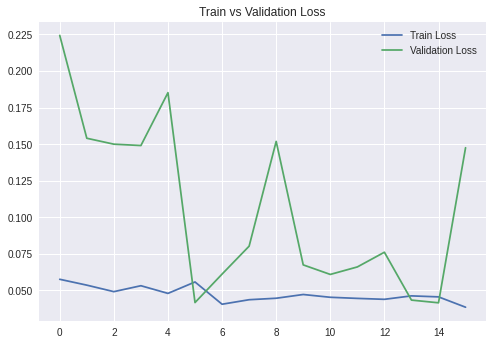

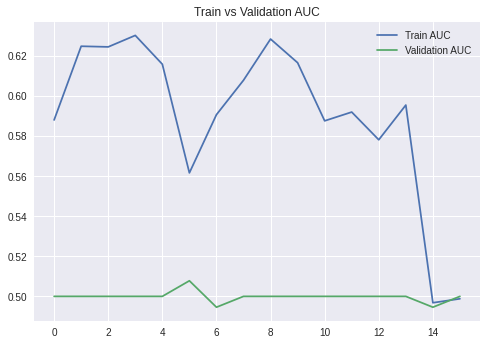


-------------------------------
Best metrics for validation set on Epoch 6:
Loss::      0.0417
AUC::       0.5078
Accuracy::  0.7535
F1::        0.1020
Precision:: 0.2778
Recall::    0.0625
Confusion Matrix:
 [[264  13]
 [ 75   5]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:1 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

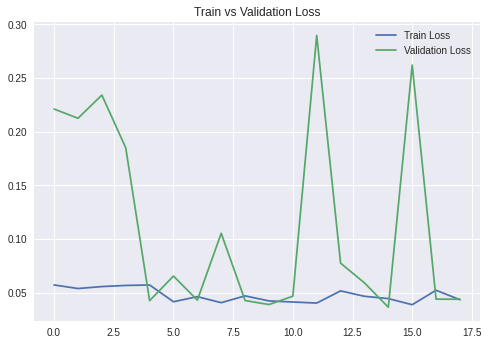

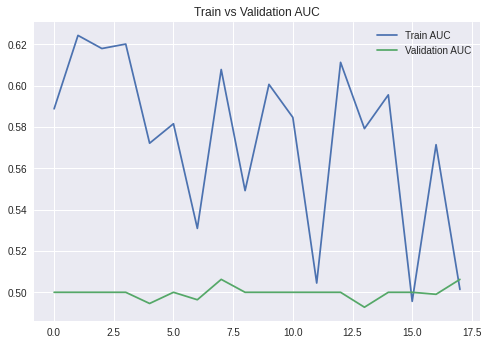


-------------------------------
Best metrics for validation set on Epoch 8:
Loss::      0.1053
AUC::       0.5062
Accuracy::  0.7787
F1::        0.0247
Precision:: 1.0000
Recall::    0.0125
Confusion Matrix:
 [[277   0]
 [ 79   1]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:2 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

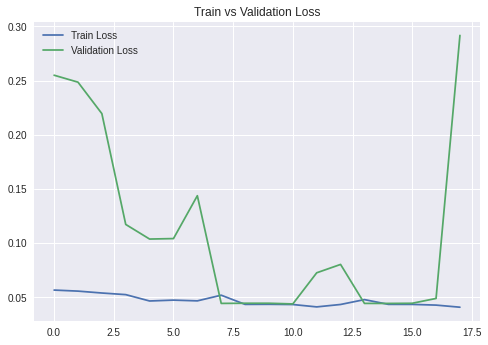

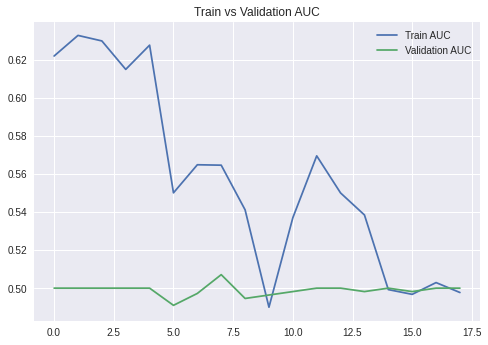


-------------------------------
Best metrics for validation set on Epoch 8:
Loss::      0.0443
AUC::       0.5071
Accuracy::  0.7731
F1::        0.0471
Precision:: 0.4000
Recall::    0.0250
Confusion Matrix:
 [[274   3]
 [ 78   2]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:3 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

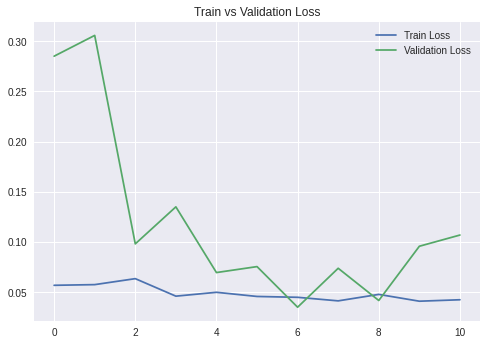

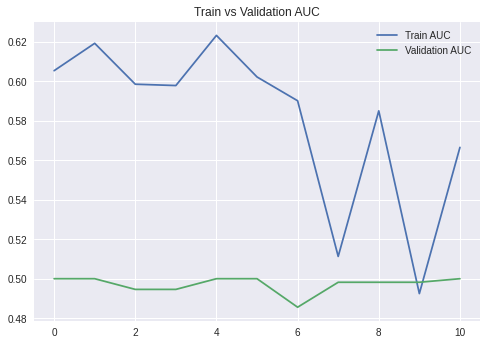


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.2850
AUC::       0.5000
Accuracy::  0.7737
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[277   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:4 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

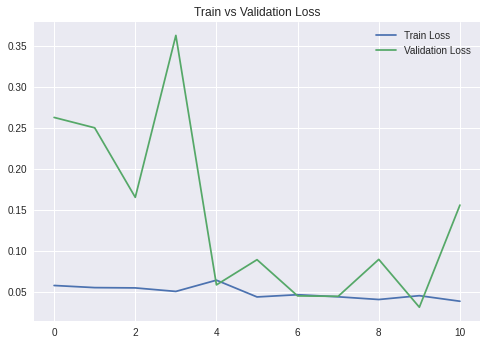

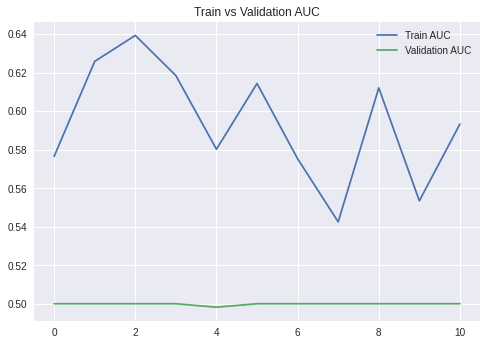


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.2627
AUC::       0.5000
Accuracy::  0.7737
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[277   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:5 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

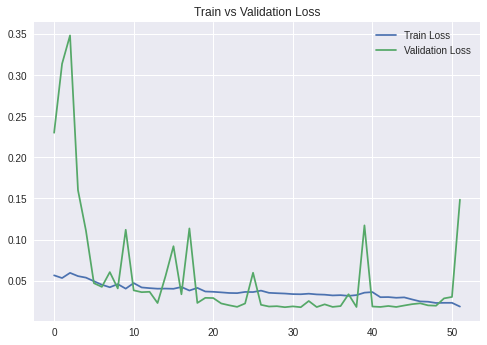

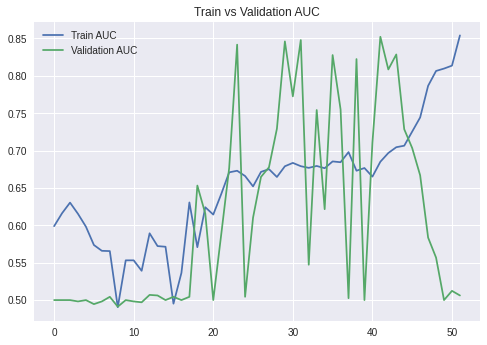


-------------------------------
Best metrics for validation set on Epoch 42:
Loss::      0.0180
AUC::       0.8521
Accuracy::  0.8184
F1::        0.6948
Precision:: 0.5606
Recall::    0.9136
Confusion Matrix:
 [[219  58]
 [  7  74]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:6 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

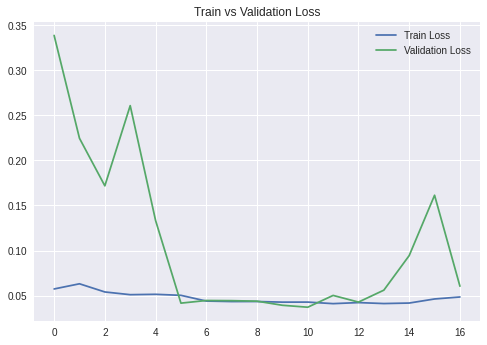

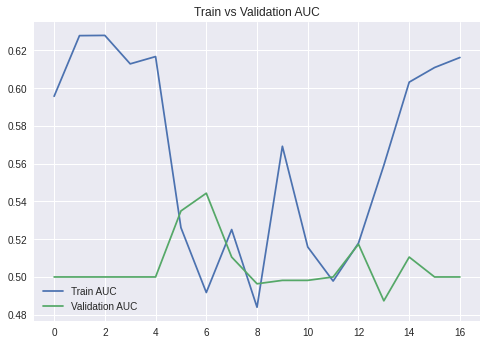


-------------------------------
Best metrics for validation set on Epoch 7:
Loss::      0.0445
AUC::       0.5444
Accuracy::  0.3017
F1::        0.3902
Precision:: 0.2432
Recall::    0.9877
Confusion Matrix:
 [[ 28 249]
 [  1  80]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:7 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

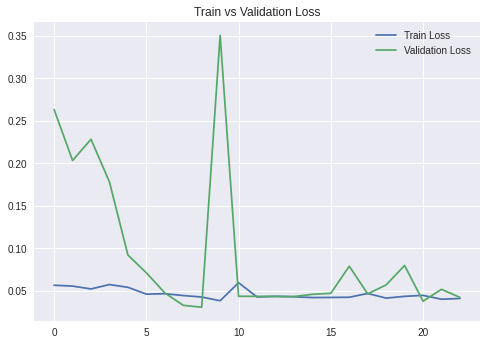

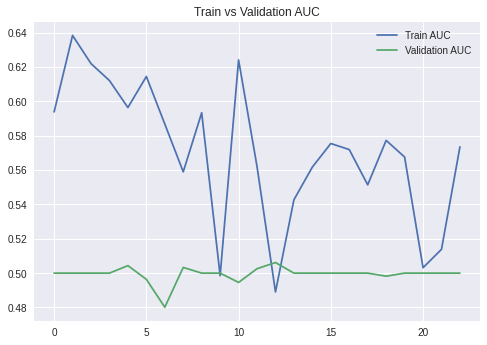


-------------------------------
Best metrics for validation set on Epoch 13:
Loss::      0.0432
AUC::       0.5062
Accuracy::  0.7765
F1::        0.0244
Precision:: 1.0000
Recall::    0.0123
Confusion Matrix:
 [[277   0]
 [ 80   1]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:8 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

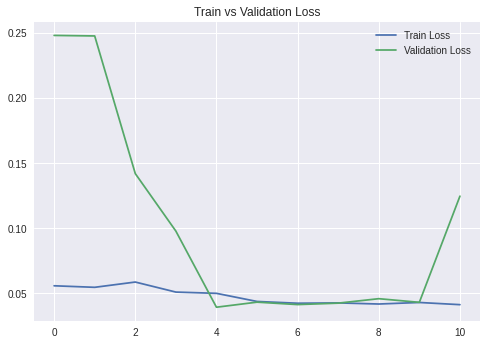

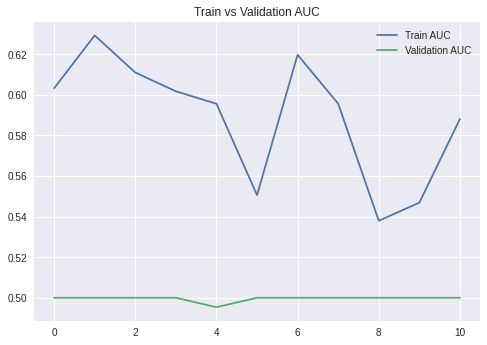


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.2482
AUC::       0.5000
Accuracy::  0.7737
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[277   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:9 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

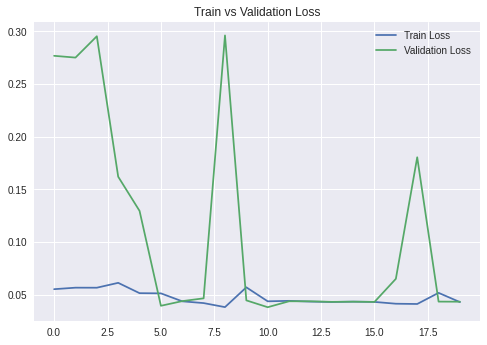

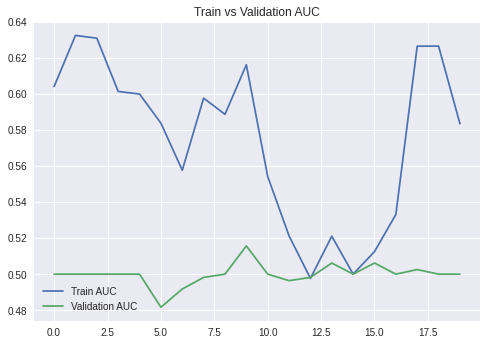


-------------------------------
Best metrics for validation set on Epoch 10:
Loss::      0.0446
AUC::       0.5157
Accuracy::  0.7709
F1::        0.0889
Precision:: 0.4444
Recall::    0.0494
Confusion Matrix:
 [[272   5]
 [ 77   4]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:10 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

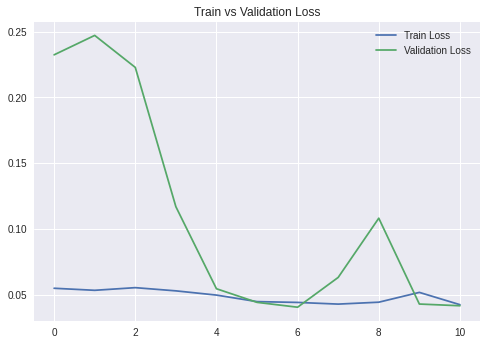

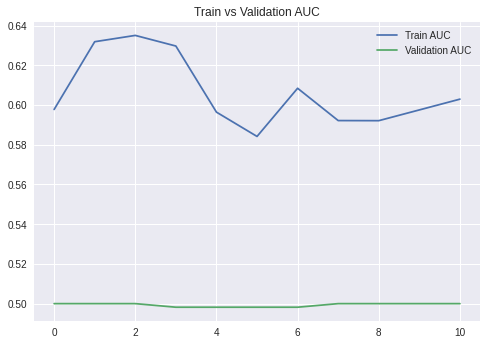


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.2323
AUC::       0.5000
Accuracy::  0.7744
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[278   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:11 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

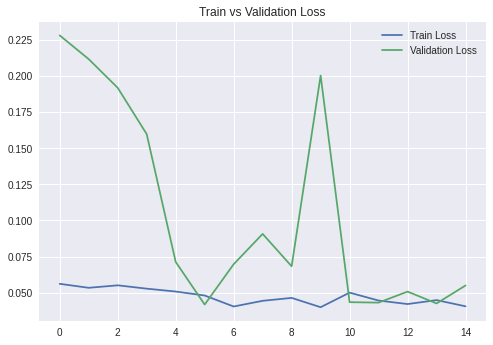

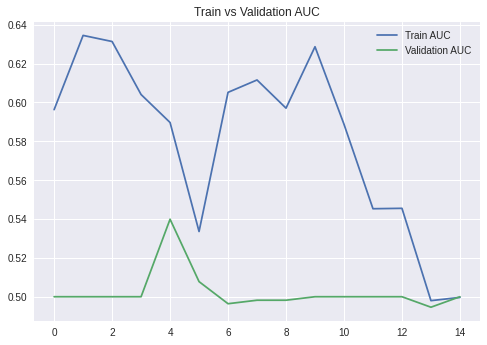


-------------------------------
Best metrics for validation set on Epoch 5:
Loss::      0.0713
AUC::       0.5399
Accuracy::  0.7549
F1::        0.2143
Precision:: 0.3871
Recall::    0.1481
Confusion Matrix:
 [[259  19]
 [ 69  12]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:12 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

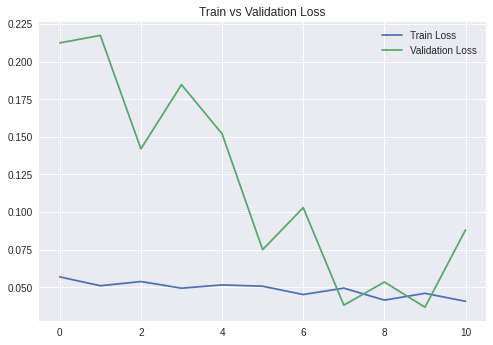

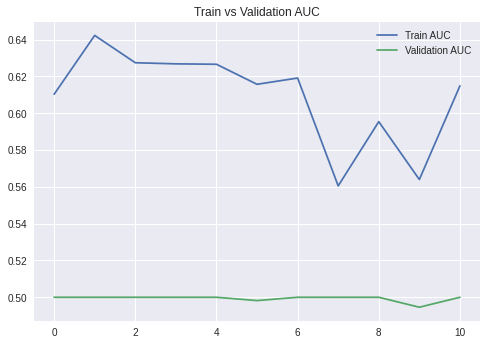


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.2124
AUC::       0.5000
Accuracy::  0.7744
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[278   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:13 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [ ]:
df_results_vgg13_bn_a2 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('axial',list(range(0,50)))
                                         ],
                          num_repeats = 1,
                          model='vgg13_bn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_VGG13_AXIAL2.csv')

In [ ]:
df_results_vgg13_bn_a2.sort_values("validation_auc",ascending=False)

# Shallow CNN


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:0 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

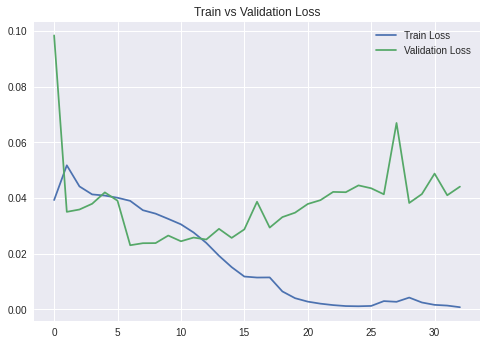

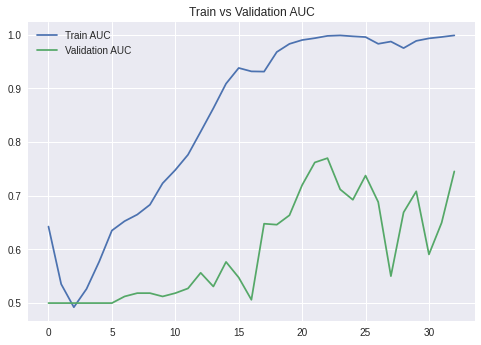


-------------------------------
Best metrics for validation set on Epoch 23:
Loss::      0.0421
AUC::       0.7698
Accuracy::  0.8333
F1::        0.6386
Precision:: 0.6235
Recall::    0.6543
Confusion Matrix:
 [[247  32]
 [ 28  53]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:1 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

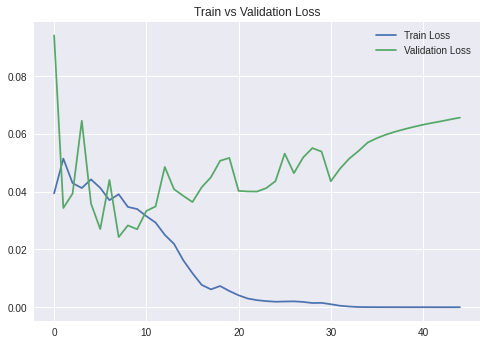

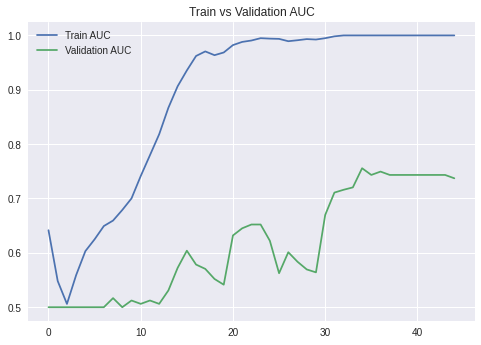


-------------------------------
Best metrics for validation set on Epoch 35:
Loss::      0.0570
AUC::       0.7557
Accuracy::  0.8250
F1::        0.6182
Precision:: 0.6071
Recall::    0.6296
Confusion Matrix:
 [[246  33]
 [ 30  51]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:2 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

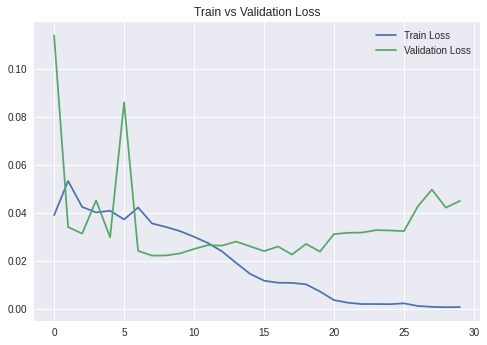

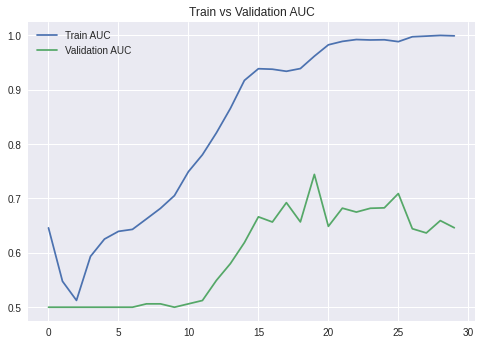


-------------------------------
Best metrics for validation set on Epoch 20:
Loss::      0.0238
AUC::       0.7443
Accuracy::  0.8278
F1::        0.6076
Precision:: 0.6234
Recall::    0.5926
Confusion Matrix:
 [[250  29]
 [ 33  48]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:3 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

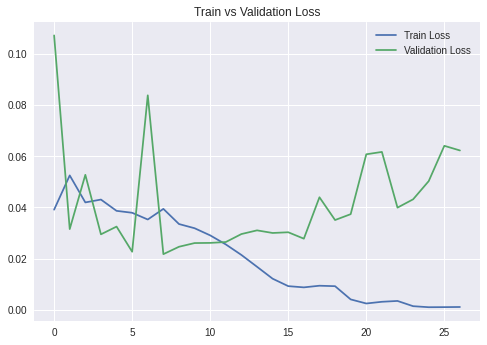

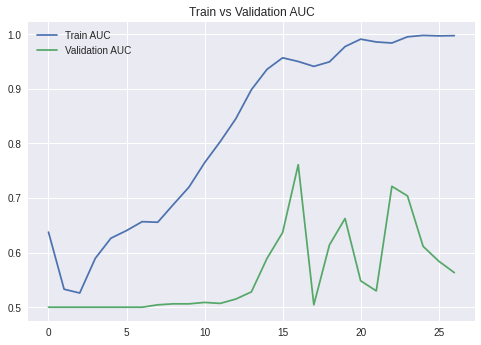


-------------------------------
Best metrics for validation set on Epoch 17:
Loss::      0.0278
AUC::       0.7611
Accuracy::  0.8333
F1::        0.6296
Precision:: 0.6296
Recall::    0.6296
Confusion Matrix:
 [[249  30]
 [ 30  51]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:4 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

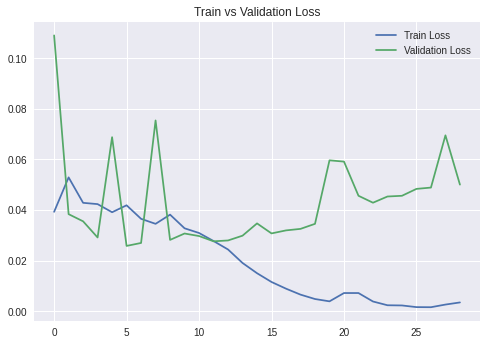

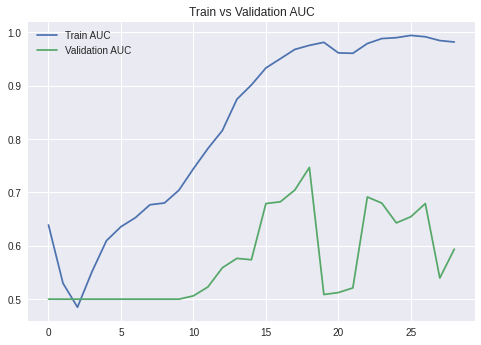


-------------------------------
Best metrics for validation set on Epoch 19:
Loss::      0.0346
AUC::       0.7469
Accuracy::  0.8250
F1::        0.6087
Precision:: 0.6125
Recall::    0.6049
Confusion Matrix:
 [[248  31]
 [ 32  49]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:5 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

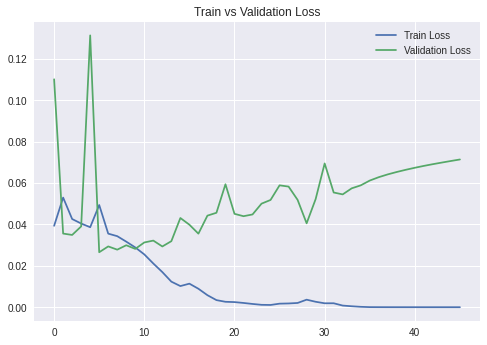

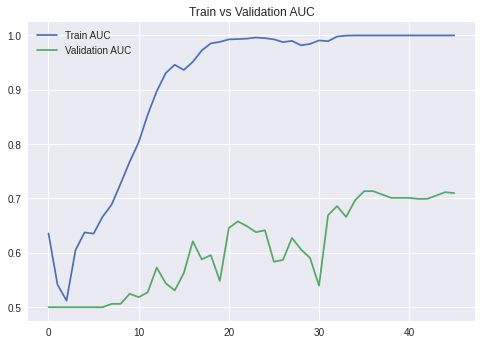


-------------------------------
Best metrics for validation set on Epoch 36:
Loss::      0.0612
AUC::       0.7135
Accuracy::  0.8139
F1::        0.5621
Precision:: 0.5972
Recall::    0.5309
Confusion Matrix:
 [[250  29]
 [ 38  43]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:6 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

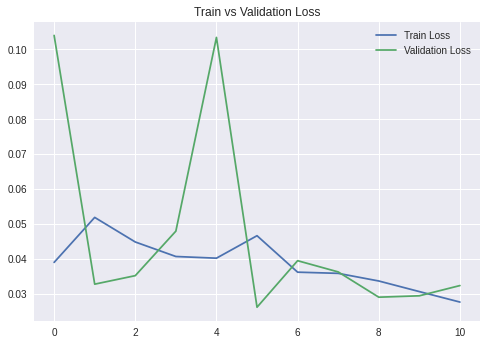

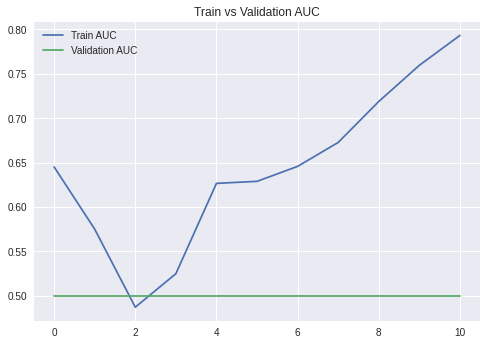


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.1040
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:7 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

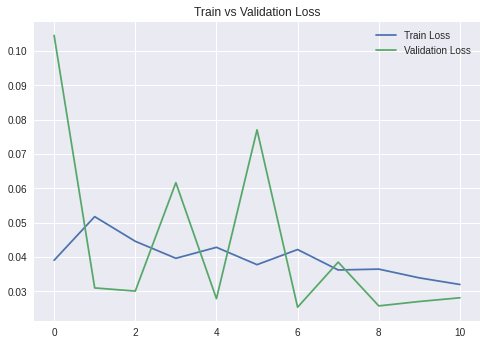

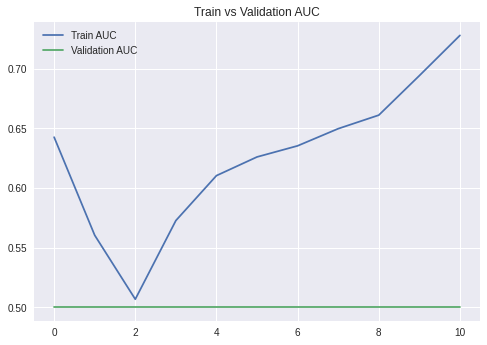


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.1045
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:8 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

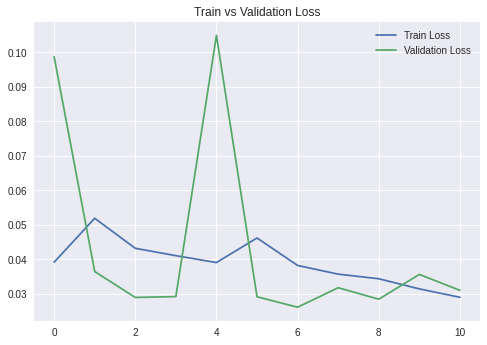

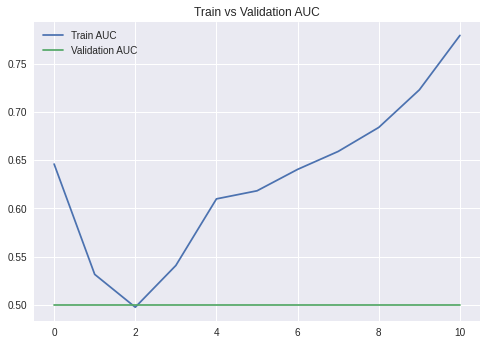


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.0987
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:9 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

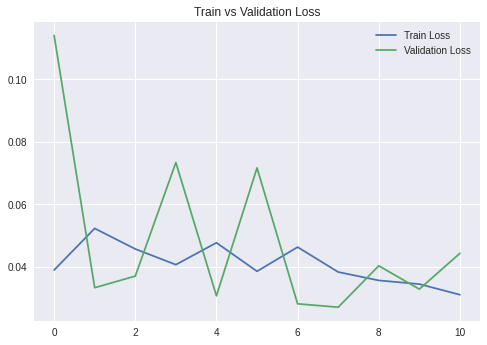

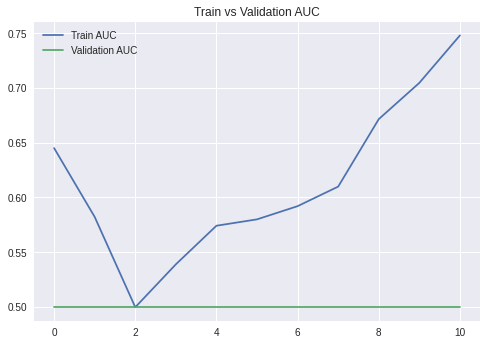


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.1140
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:10 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

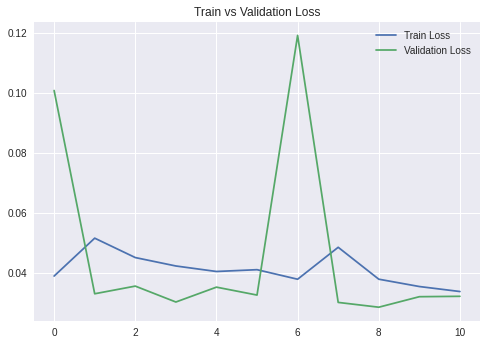

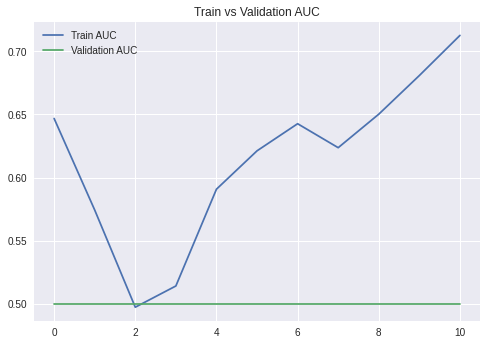


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.1008
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:11 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

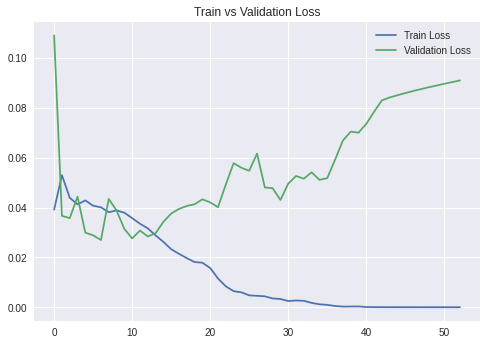

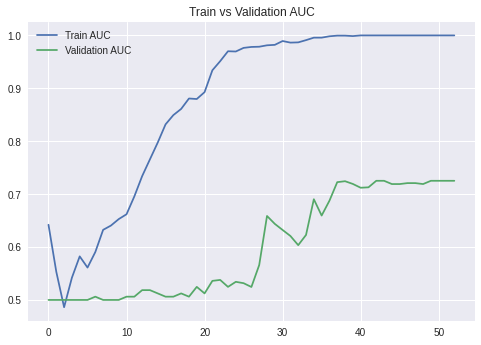


-------------------------------
Best metrics for validation set on Epoch 43:
Loss::      0.0830
AUC::       0.7252
Accuracy::  0.7778
F1::        0.5604
Precision:: 0.5050
Recall::    0.6296
Confusion Matrix:
 [[229  50]
 [ 30  51]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:12 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

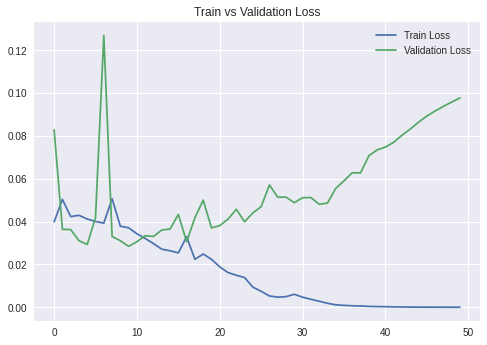

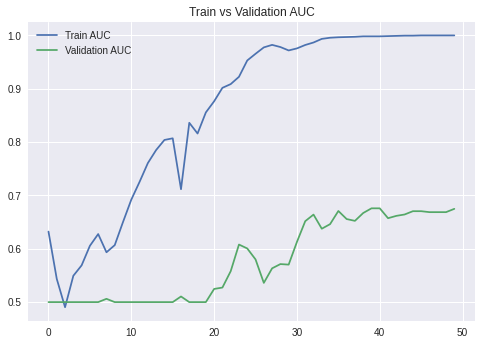


-------------------------------
Best metrics for validation set on Epoch 40:
Loss::      0.0734
AUC::       0.6758
Accuracy::  0.7556
F1::        0.4943
Precision:: 0.4624
Recall::    0.5309
Confusion Matrix:
 [[229  50]
 [ 38  43]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:13 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

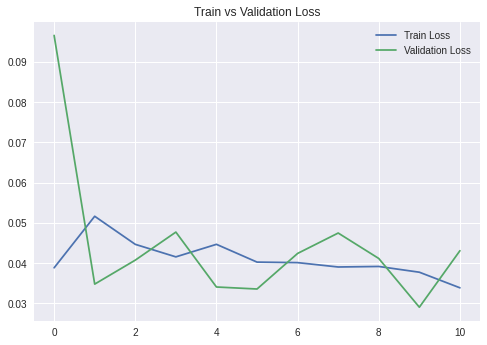

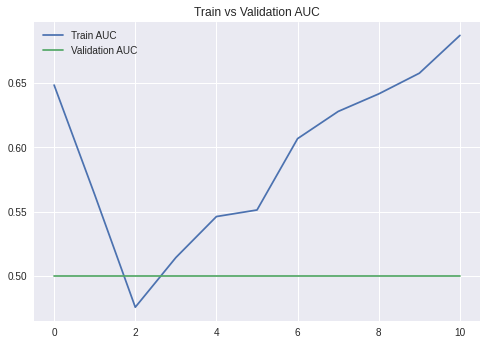


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.0966
AUC::       0.5000
Accuracy::  0.7750
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 81   0]]
-------------------------------


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:14 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
NeuralNetwork(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [ ]:
df_results_shallow_c1 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('coronal',list(range(0,50)))
                                         ],
                          num_repeats = 1,
                          model='shallow_cnn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_SHALLOW_CORONAL1.csv')

In [ ]:
df_results_shallow_c1.sort_values("validation_auc",ascending=False)

In [ ]:
df_results_shallow_c2 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('coronal',list(range(14,100)))
                                         ],
                          num_repeats = 1,
                          model='shallow_cnn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_SHALLOW_CORONAL2.csv')

In [ ]:
df_results_shallow_c2.sort_values("validation_auc",ascending=False)

In [ ]:
df_results_shallow_a1 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('axial',list(range(0,50)))
                                         ],
                          num_repeats = 1,
                          model='shallow_cnn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_SHALLOW_AXIAL1.csv')

In [ ]:
df_results_shallow_a1.sort_values("validation_auc",ascending=False)


In [ ]:
df_results_shallow_a2 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('axial',list(range(50,100)))
                                         ],
                          num_repeats = 1,
                          model='shallow_cnn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_SHALLOW_AXIAL2.csv')

In [ ]:
df_results_shallow_a2.sort_values("validation_auc",ascending=False)

In [ ]:
df_results_shallow_s1 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('sagittal',list(range(0,50)))
                                         ],
                          num_repeats = 1,
                          model='shallow_cnn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_SHALLOW_SAGITTAL1.csv')

In [ ]:
df_results_shallow_s1.sort_values("validation_auc",ascending=False)


In [ ]:
df_results_shallow_s2 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('sagittal',list(range(50,100)))
                                         ],
                          num_repeats = 1,
                          model='shallow_cnn',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.0001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_SHALLOW_SAGITTAL2.csv')

In [ ]:
df_results_shallow_s2.sort_values("validation_auc",ascending=False)


# Resnet34

In [ ]:
df_results_resnet34 = run_mris_experiments(
                          orientation_and_slices = [
                                         ('sagittal',list(range(0,100))),
                                         ('axial',list(range(0,100))),
                                         ('coronal',list(range(0,100)))
                                         ],
                          num_repeats = 1,
                          model='resnet34',
                          classes=['MCI','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':1,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211030_2026.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                          },
                          additional_experiment_params = {'lr':0.001,
                            'batch_size':16,
                            'optimizer':'adam',
                            'max_epochs':100,
                            'early_stop':10,
                            'prediction_threshold':0.5}
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_MCI_RESNET34.csv')

In [ ]:
df_results_resnet34.sort_values("validation_auc",ascending=False)

# Comparing Distributions of VGG11 and VGG13

Results: VGG13 shows slightly better performance on average. The Wilcoxon test confirms the alternative hypothesis that the VGG11 and VGG13 results are different with a 94% confidence interval.

In [ ]:
train_size = 1713
validation_size = 357
test_size = 349

In [ ]:
df_vgg_coronal = pd.read_csv('/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_CORONAL_VGG11.csv')
df_vgg_axial = pd.read_csv('/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_AXIAL_VGG11.csv')
df_vgg_sagittal = pd.read_csv('/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_SAGITTAL_VGG11.csv')

df_vgg11_adapted = pd.concat([df_vgg_coronal,df_vgg_axial,df_vgg_sagittal])
df_vgg11_adapted['orientation'] = [x.split('_')[0] for x in df_vgg11_adapted['RUN_ID']]
df_vgg11_adapted['slice'] = [x.split('_')[1] for x in df_vgg11_adapted['RUN_ID']]
df_vgg11_adapted['run'] = [x.split('_')[2] for x in df_vgg11_adapted['RUN_ID']]

df_vgg11_adapted['train_size'] = train_size
df_vgg11_adapted['validation_size'] = validation_size
df_vgg11_adapted['test_size'] = test_size

df_vgg11_adapted = df_vgg11_adapted[['validation_auc','train_auc','validation_f1score','train_f1score','orientation','slice','run','train_size','validation_size']]
df_vgg11_adapted = df_vgg11_adapted.groupby(['orientation','slice']).mean().sort_values('validation_auc',ascending=False).reset_index()
df_vgg11_adapted['id'] = df_vgg11_adapted['orientation'] + df_vgg11_adapted['slice'].astype(str)
top10_vgg11_adapted = df_vgg11_adapted.head(10)
top10_vgg11_adapted

,orientation,slice,validation_auc,train_auc,validation_f1score,train_f1score,train_size,validation_size,id
0,sagittal,26,0.864305,0.855493,0.726807,0.805354,1713,357,sagittal26
1,sagittal,27,0.863432,0.945209,0.740370,0.925765,1713,357,sagittal27
2,sagittal,76,0.850060,0.829570,0.756775,0.766538,1713,357,sagittal76
3,axial,20,0.846131,0.931030,0.750010,0.906067,1713,357,axial20
4,sagittal,24,0.836941,0.899364,0.705944,0.862147,1713,357,sagittal24
5,sagittal,23,0.836159,0.903834,0.714976,0.875324,1713,357,sagittal23
6,sagittal,73,0.833218,0.818445,0.741274,0.750750,1713,357,sagittal73
7,sagittal,28,0.832483,0.911408,0.711872,0.876999,1713,357,sagittal28
8,sagittal,72,0.832116,0.918011,0.731257,0.892541,1713,357,sagittal72
9,sagittal,74,0.828554,0.942203,0.705673,0.924381,1713,357,sagittal74


In [ ]:
df_vgg11 = pd.read_csv('/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_VGG11.csv')

df_vgg11['train_size'] = train_size
df_vgg11['validation_size'] = validation_size
df_vgg11['test_size'] = test_size

df_vgg11 = df_vgg11[['validation_auc','train_auc','validation_f1score','train_f1score','orientation','slice','run','train_size','validation_size']]
df_vgg11 = df_vgg11.groupby(['orientation','slice']).mean().sort_values('validation_auc',ascending=False).reset_index()
df_vgg11['id'] = df_vgg11['orientation'] + df_vgg11['slice'].astype(str)

top10_vgg11 = df_vgg11.head(10)
top10_vgg11.head(10)

,orientation,slice,validation_auc,train_auc,validation_f1score,train_f1score,run,train_size,validation_size,id
0,sagittal,26,0.870738,0.904434,0.718462,0.873881,2,1713,357,sagittal26
1,sagittal,28,0.851117,0.946156,0.732620,0.927365,2,1713,357,sagittal28
2,axial,20,0.849646,0.919648,0.745684,0.891517,2,1713,357,axial20
3,sagittal,74,0.843741,0.838788,0.743183,0.778277,2,1713,357,sagittal74
4,sagittal,27,0.841834,0.881337,0.696889,0.839071,2,1713,357,sagittal27
5,sagittal,75,0.836067,0.873326,0.719369,0.829914,2,1713,357,sagittal75
6,sagittal,23,0.834919,0.951164,0.686681,0.935576,2,1713,357,sagittal23
7,sagittal,24,0.832162,0.933871,0.697136,0.908984,2,1713,357,sagittal24
8,coronal,56,0.829221,0.912976,0.720386,0.889499,2,1713,357,coronal56
9,sagittal,73,0.829037,0.875068,0.730066,0.827831,2,1713,357,sagittal73


In [ ]:
df_vgg13 = pd.read_csv('/content/gdrive/MyDrive/Lucas_Thimoteo/data/RESULTS_VGG13_BN.csv')

df_vgg13['train_size'] = train_size
df_vgg13['validation_size'] = validation_size
df_vgg13['test_size'] = test_size

df_vgg13 = df_vgg13[['validation_auc','train_auc','validation_f1score','train_f1score','orientation','slice','run','train_size','validation_size']]
df_vgg13 = df_vgg13.groupby(['orientation','slice']).mean().sort_values('validation_auc',ascending=False).reset_index()
df_vgg13['id'] = df_vgg13['orientation'] + df_vgg13['slice'].astype(str)

top10_vgg13 = df_vgg13.head(10)
top10_vgg13

,orientation,slice,validation_auc,train_auc,validation_f1score,train_f1score,run,train_size,validation_size,id
0,sagittal,28,0.852610,0.956546,0.773764,0.940965,2,1713,357,sagittal28
1,sagittal,26,0.851277,0.926909,0.741363,0.899212,2,1713,357,sagittal26
2,coronal,43,0.848291,0.937316,0.733205,0.917380,2,1713,357,coronal43
3,sagittal,23,0.846843,0.967057,0.727794,0.957851,2,1713,357,sagittal23
4,sagittal,74,0.845602,0.970484,0.764961,0.959136,2,1713,357,sagittal74
5,sagittal,75,0.845511,0.962591,0.769896,0.951067,2,1713,357,sagittal75
6,sagittal,27,0.843351,0.935360,0.714198,0.911859,2,1713,357,sagittal27
7,sagittal,72,0.833632,0.973417,0.752805,0.964926,2,1713,357,sagittal72
8,sagittal,76,0.831702,0.946594,0.724728,0.931185,2,1713,357,sagittal76
9,axial,23,0.831288,0.935314,0.707751,0.910852,2,1713,357,axial23


In [ ]:
from scipy.stats import wilcoxon

In [ ]:
val_auc_vgg11 = df_vgg11.sort_values(['orientation','slice']).reset_index(drop=True)['validation_auc'].tolist()
val_auc_vgg13 = df_vgg13.sort_values(['orientation','slice']).reset_index(drop=True)['validation_auc'].tolist()

In [ ]:
stat,pvalue = wilcoxon(x=val_auc_vgg13, y=val_auc_vgg11, zero_method='wilcox', correction=False, alternative='two-sided')

print("Validation AUC VGG11: %.2f +/- %.2f" % (np.mean(val_auc_vgg11),np.std(val_auc_vgg11)))
print("Validation AUC VGG13: %.2f +/- %.2f" % (np.mean(val_auc_vgg13),np.std(val_auc_vgg13)))
print("Distributions of VGG13 vs VGG11")
print(f"Alternative hypothesis: {stat} with p-value=%.4f" % pvalue)

Validation AUC VGG11: 0.82 +/- 0.03
Validation AUC VGG13: 0.82 +/- 0.02
Distributions of VGG13 vs VGG11
Alternative hypothesis: 94.0 with p-value=0.0653


In [ ]:
new_ids = df_vgg11['id'].tolist()
df_vgg11_adapted = df_vgg11_adapted.query("id in @new_ids")
new_ids = df_vgg11_adapted['id']

df_vgg11 = df_vgg11.query("id in @new_ids")
df_vgg13 = df_vgg13.query("id in @new_ids")

In [ ]:
val_auc_vgg11_adapted = df_vgg11_adapted.sort_values(['orientation','slice']).reset_index(drop=True)['validation_auc'].tolist()
val_auc_vgg11 = df_vgg11.sort_values(['orientation','slice']).reset_index(drop=True)['validation_auc'].tolist()
val_auc_vgg13 = df_vgg13.sort_values(['orientation','slice']).reset_index(drop=True)['validation_auc'].tolist()

In [ ]:
stat,pvalue = wilcoxon(x=val_auc_vgg11_adapted, y=val_auc_vgg11, zero_method='wilcox', correction=False, alternative='two-sided')

print("Validation AUC VGG11_2048: %.2f +/- %.2f" % (np.mean(val_auc_vgg11_adapted),np.std(val_auc_vgg11_adapted)))
print("Validation AUC VGG11: %.2f +/- %.2f" % (np.mean(val_auc_vgg11),np.std(val_auc_vgg11)))
print("Distributions of VGG13 vs VGG11")
print(f"Alternative hypothesis: {stat} with p-value=%.4f" % pvalue)

Validation AUC VGG11_2048: 0.82 +/- 0.02
Validation AUC VGG11: 0.82 +/- 0.03
Distributions of VGG13 vs VGG11
Alternative hypothesis: 102.0 with p-value=0.6389


In [ ]:
stat,pvalue = wilcoxon(x=val_auc_vgg13, y=val_auc_vgg11_adapted, zero_method='wilcox', correction=False, alternative='two-sided')

print("Validation AUC VGG11_adapted: %.2f +/- %.2f" % (np.mean(val_auc_vgg11_adapted),np.std(val_auc_vgg11_adapted)))
print("Validation AUC VGG13: %.2f +/- %.2f" % (np.mean(val_auc_vgg13),np.std(val_auc_vgg13)))
print("Distributions of VGG13 vs VGG11_adapted")
print(f"Alternative hypothesis: {stat} with p-value=%.4f" % pvalue)

Validation AUC VGG11_adapted: 0.82 +/- 0.02
Validation AUC VGG13: 0.82 +/- 0.02
Distributions of VGG13 vs VGG11_adapted
Alternative hypothesis: 88.0 with p-value=0.3392


Here we see no difference between the VGG11 adapted and the VGG11 and VGG13. Important to notice that the sample size here is really limited, aprox 21.

In [ ]:
all_tops = pd.concat([top10_vgg13,top10_vgg11,top10_vgg11_adapted])[['orientation','slice']]
all_tops['slice'] = all_tops['slice'].astype(int)
all_tops.sort_values(['orientation','slice'],inplace=True)
all_tops = all_tops.drop_duplicates().reset_index(drop=True)
all_tops

,orientation,slice
0,axial,20
1,axial,23
2,coronal,43
3,coronal,56
4,sagittal,23
5,sagittal,24
6,sagittal,26
7,sagittal,27
8,sagittal,28
9,sagittal,72


In [ ]:
all_tops.groupby('orientation').agg({'slice':lambda x: list(x)})


,slice
orientation,
axial,"[20, 23]"
coronal,"[43, 56]"
sagittal,"[23, 24, 26, 27, 28, 72, 73, 74, 75, 76]"
